In [1]:
import os
import h5py
import shutil
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
from astropy import table
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import csv


In [2]:
hf = h5py.File(os.path.expandvars('$SCRATCH') + "/test.h5", "r")


In [11]:
hf.keys()

<KeysViewHDF5 ['134.283', '135.283', '136.282', '136.283', '137.282', '137.283', '138.281', '138.282', '138.283', '139.281', '139.282', '139.283', '140.280', '140.281', '140.282', '140.283', '141.280', '141.281', '141.282', '141.283', '148.276', '149.275', '149.276', '150.274', '150.275', '150.276', '151.274', '151.275', '151.276', '152.274', '152.275', '152.276', '153.272', '153.273', '153.274', '153.275', '153.276', '154.271', '154.272', '154.273']>

In [8]:
w = np.array(hf.get('134.283/IMAGES/c10'))

In [5]:
test = np.random.normal(scale = 0.1,size = (60,60))

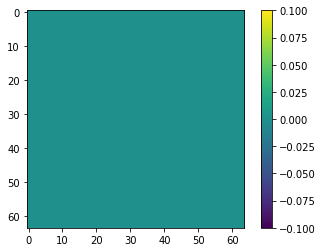

In [9]:
plt.imshow(w[...,0])
plt.colorbar()

In [3]:
scratch = os.path.expandvars("$SCRATCH") + '/'
image_dir = "/home/anahoban/projects/rrg-kyi/astro/cfis/W3/"

## Create Cutout Files

In [4]:
def create_cutouts(img, wt, x, y, band):
    ''' Creates the image and weight cutouts given a tile, the position of the center and the band '''
    
    img_cutout = Cutout2D(img.data, (x, y), cutout_size, mode="partial", fill_value=0).data
    if np.count_nonzero(np.isnan(img_cutout)) >= 0.05*cutout_size**2 or np.count_nonzero(img_cutout) == 0: # Don't use this cutout
        return (None, None)
    wt_cutout = Cutout2D(wt.data, (x, y), cutout_size, mode="partial", fill_value=0).data
    img_cutout[np.isnan(img_cutout)] = 0
    wt_cutout[np.isnan(wt_cutout)] = 0
    
    #img_lower = np.percentile(img_cutout, 1)
    #img_upper = np.percentile(img_cutout, 99)
    
    img_lower = np.percentile(img_cutout, 0.001)
    img_upper = np.percentile(img_cutout, 99.999)
    
    img_cutout[img_cutout<img_lower] = img_lower
    img_cutout[img_cutout>img_upper] = img_upper
    #wt_cutout[wt_cutout<img_lower] = img_lower
    #wt_cutout[wt_cutout>img_upper] = img_upper
    
    
    if img_lower == img_upper:
        img_norm = np.zeros((cutout_size, cutout_size))
        inorms.append(-1)
    else:
        img_norm = (img_cutout - np.min(img_cutout)) / (img_upper - img_lower)
        inorms.append(1/(img_upper - img_lower))
        
    #if (band != "u" or band != "r") and img_upper != img_lower: # Alter weights for PS1
    #    wt_norm = (wt_cutout - np.min(wt_cutout)) / (img_upper - img_lower)
    #    wnorms.append(1/(img_upper - img_lower))
    #else: # Do not alter weights for CFIS
    wt_norm = wt_cutout
    
        
    return (img_norm, wt_norm)

In [54]:
tile_list = open(image_dir + "tiles.list", "r")
hf = h5py.File(scratch + "test_weightnotnorm.h5", "w")
hf.close()

In [55]:
os.remove(os.path.expandvars("$SLURM_TMPDIR") + "/test_weightnotnorm.h5")

FileNotFoundError: [Errno 2] No such file or directory: '/localscratch/anahoban.4019865.0/test_weightnotnorm.h5'

In [57]:
#intitialize file in tmpdir, to work there
src = os.path.expandvars("$SCRATCH") + "/test_weightnotnorm.h5"
dest = os.path.expandvars("$SLURM_TMPDIR") + "/"
shutil.copy2(src, dest)

'/localscratch/anahoban.4019865.0/test_weightnotnorm.h5'

In [58]:
hf = h5py.File(dest + "test_weightnotnorm.h5", "r+")

In [59]:
inorms = []
#wnorms = []

In [29]:
u_images = []; u_weights = []
r_images = []; r_weights = []
u_cat = []
r_cat = []
for tile in tile_list:
    tile = tile[:-1] # Remove new line character
    channels = tile.split(" ") #tile.channel tile.channel ... (we just want tiles with all 5 channels)
    if len(channels) == 5: # Order is u,g,r,i,z
        u_images.append(image_dir + channels[0] + ".fits")
        u_weights.append(image_dir + channels[0] + ".weight.fits.fz")
        r_images.append(image_dir + channels[2] + ".fits")
        r_weights.append(image_dir + channels[2] + ".weight.fits.fz")
        
        u_cat.append(image_dir + channels[0] + ".cat")
        r_cat.append(image_dir + channels[2] + ".cat")
tile_list.close()

In [30]:
# Copy tiles to $SLURM_TMPDIR
start = 0
end = 3
for n in range(start, end):
    shutil.copy2(u_images[n], dest)
    shutil.copy2(u_weights[n], dest)
    shutil.copy2(r_images[n], dest)
    shutil.copy2(r_weights[n], dest)
    #shutil.copy2(u_cat[n], dest)
    shutil.copy2(r_cat[n], dest)
    
    u_images[n] = os.path.abspath(dest + os.path.basename(u_images[n]))
    u_weights[n] = os.path.abspath(dest + os.path.basename(u_weights[n]))
    r_images[n] = os.path.abspath(dest + os.path.basename(r_images[n]))
    r_weights[n] = os.path.abspath(dest + os.path.basename(r_weights[n])) 
    #u_cat[n] = os.path.abspath(dest + os.path.basename(u_cat[n]))
    r_cat[n] = os.path.abspath(dest + os.path.basename(r_cat[n]))

In [60]:
len(u_cat)

41

In [61]:
cutout_size = 64
start = 0
end = 2
img_cutout = np.zeros((cutout_size, cutout_size, 5))
wt_cutout = np.zeros((cutout_size, cutout_size, 5))
for n in range(start, end):
    root = os.path.basename(u_images[n])[5:12] + "/" # XXX.XXX id
    
    u_image = fits.open(u_images[n], memmap=True)
    u_weight = fits.open(u_weights[n], memmap=True)
    r_image = fits.open(r_images[n], memmap=True)
    r_weight = fits.open(r_weights[n], memmap=True)
    main_cat = table.Table.read(r_cat[n], format="ascii.sextractor")
    #app_cat = table.Table.read(u_cat[n], format="ascii.sextractor")
    
    img_group = hf.create_group(root + "IMAGES")
    wt_group = hf.create_group(root + "WEIGHTS")

    count = 0
    #cutouts from r band
    for i in range(len(main_cat)): #each cutout in tile
        if main_cat["FLAGS"][i] != 0 or main_cat["MAG_AUTO"][i] >= 99.0 or main_cat["MAGERR_AUTO"][i] <= 0 or main_cat["MAGERR_AUTO"][i] >= 1:
            continue
        
        x = main_cat["X_IMAGE"][i]
        y = main_cat["Y_IMAGE"][i]
        
        (r_img, r_wt) = create_cutouts(r_image[0], r_weight[1], x, y, "r")
        if r_img is None:
            continue
        (u_img, u_wt) = create_cutouts(u_image[0], u_weight[1], x, y, "u")
        if u_img is None:
            continue
        img_cutout[:,:,0] = u_img
        img_cutout[:,:,2] = r_img
        wt_cutout[:,:,0] = u_wt
        wt_cutout[:,:,2] = r_wt
 

        img_group.create_dataset(f"c{count}", data=img_cutout)
        wt_group.create_dataset(f"c{count}", data=wt_cutout)
        count += 1
    
    u_image.close()
    u_weight.close()
    r_image.close()
    r_weight.close()
    
    print(f"Tile {n+1} completed")

Tile 1 completed
Tile 2 completed


In [62]:
hf.close()
src = os.path.expandvars("$SLURM_TMPDIR") + "/test_weightnotnorm.h5"
dest = os.path.expandvars("$SCRATCH") + "/"
shutil.copy2(src, dest)

'/scratch/anahoban/test_weightnotnorm.h5'

In [30]:
hf.close()
src = os.path.expandvars("$SLURM_TMPDIR") + "/test.h5"
dest = os.path.expandvars("$SCRATCH") + "/"
shutil.copy2(src, dest)

'/scratch/anahoban/test.h5'

## Look at cutouts and pixel/weight distributions

In [39]:
tile_ids = ['180.272', '181.271']

In [40]:
def get_cutouts(index,hfile, n_cutouts=1, cutout_size=64,  start=0):
    n = 0
        
    band_indices = [0,2]
    l = len(band_indices)
    sources = np.zeros((n_cutouts, cutout_size, cutout_size, l))
    weights = np.zeros((n_cutouts, cutout_size, cutout_size, l))

        
    img_group = hfile.get(tile_ids[index] + "/IMAGES")
    wt_group = hfile.get(tile_ids[index] + "/WEIGHTS")
    for i in range(start, len(img_group)):
        sources[n,:,:,:] = np.array(img_group.get(f"c{i}"))[:,:,band_indices]
        weights[n,:,:,:] = np.array(wt_group.get(f"c{i}"))[:,:,band_indices]
        n += 1
        if n == n_cutouts:
            return np.concatenate((sources, weights),axis=-1) # with weights

In [65]:
weight_notnorm =   get_cutouts(0, h5py.File(scratch + "/test_weightnotnorm.h5", "r"))
#nonorm = get_cutouts(0, h5py.File(scratch + "test_notnorm.h5", "r"))
#norm =  get_cutouts(0, h5py.File('/scratch/anahoban/test.h5'))

In [50]:
def plot(cutout):
    fig, axs = plt.subplots(2, 4, figsize=(15,15))
    
    axs[0, 0].imshow(cutout[0,...,0])
    axs[0, 0].set_title("u band")
    
    axs[0, 1].imshow(cutout[0,...,1])
    axs[0, 1].set_title("r band")
    
    axs[0, 2].hist(cutout[0,...,0],bins = 10)
    axs[0, 2].set_title("u band")
    
    axs[0, 3].hist(cutout[0,...,1],bins = 10)
    axs[0, 3].set_title("r band")
    
        
    axs[1, 0].imshow(cutout[0,...,2])
    axs[1, 0].set_title("weight u")
            
    axs[1, 1].imshow(cutout[0,...,3])
    axs[1, 1].set_title("weight r")
    
    axs[1, 2].hist(cutout[0,...,2], bins = 10)
    #axs[1, 2].set_title("weight u")
    
    axs[1, 3].hist(cutout[0,...,3], bins = 10)
    #axs[1, 3].set_title("weight r")

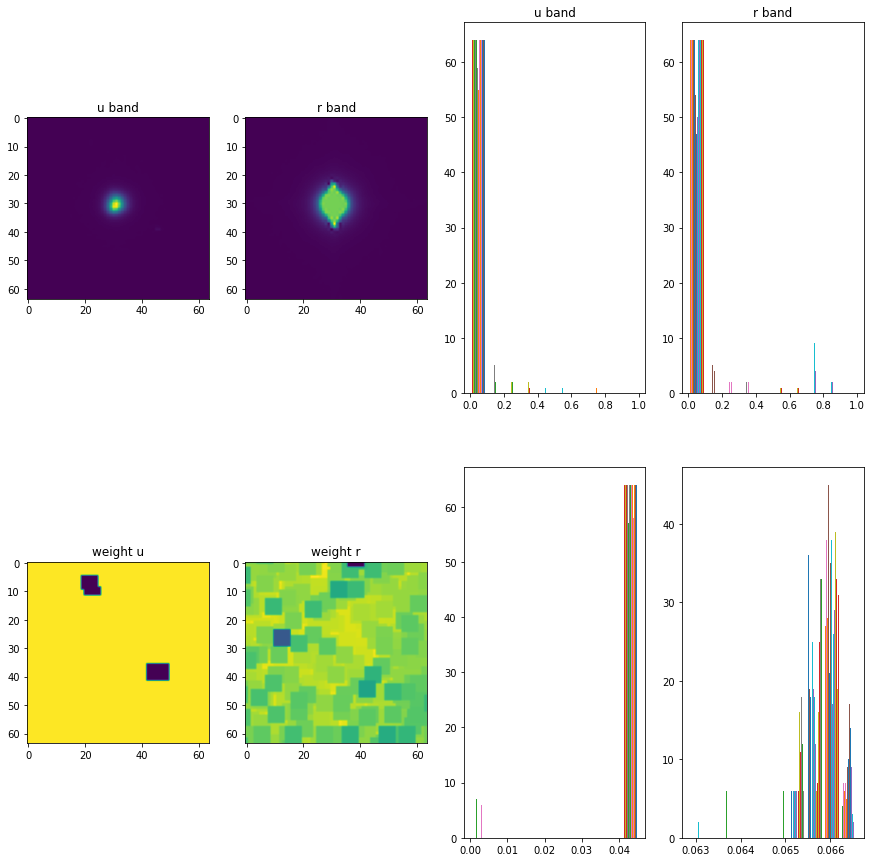

In [66]:
plot(weight_notnorm)

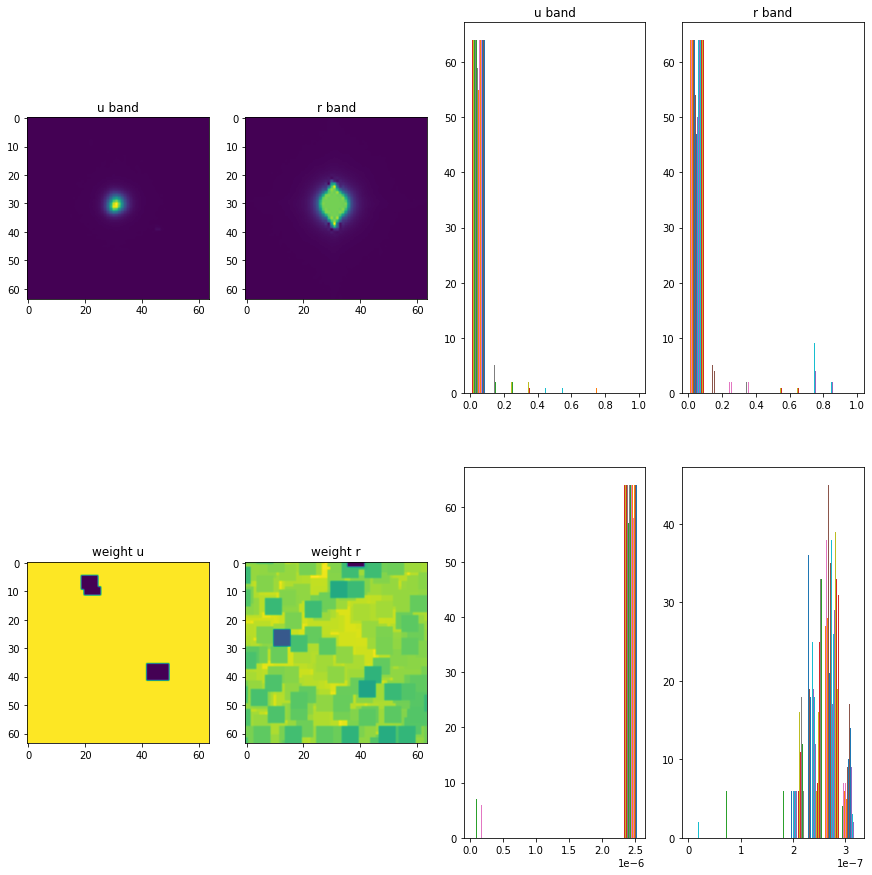

In [52]:
plot(norm)

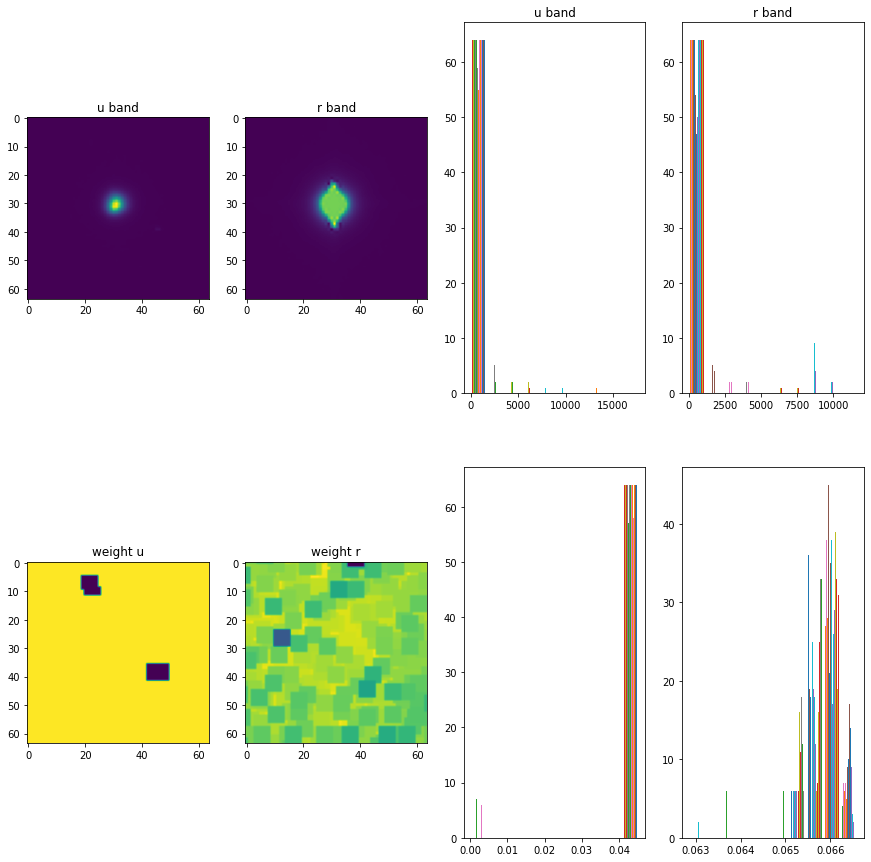

In [51]:
plot(nonorm)

In [1]:
print(len(inorms), len(wnorms))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


NameError: name 'inorms' is not defined

2.3387279018791668e-05 0.08680109709210702


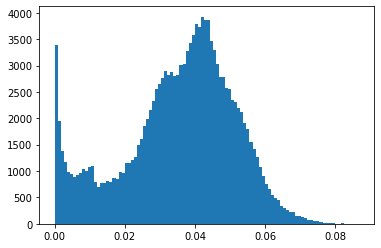

In [48]:
plt.hist(inorms, bins =100);
print(np.min(inorms),np.max(inorms))

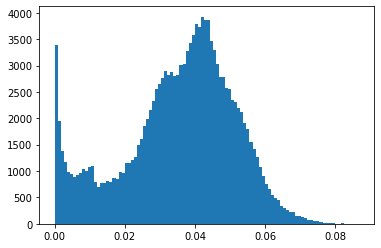

In [49]:
plt.hist(wnorms, bins=100);

## Catalogue filtering

In [10]:
cat_r = table.Table.read(r_cat[0], format="ascii.sextractor")

In [18]:
cat_r.keys()

['NUMBER',
 'X_IMAGE',
 'Y_IMAGE',
 'ALPHA_J2000',
 'DELTA_J2000',
 'MAG_AUTO',
 'MAGERR_AUTO',
 'MAG_BEST',
 'MAGERR_BEST',
 'MAG_APER',
 'MAGERR_APER',
 'A_WORLD',
 'ERRA_WORLD',
 'B_WORLD',
 'ERRB_WORLD',
 'THETA_J2000',
 'ERRTHETA_J2000',
 'ISOAREA_IMAGE',
 'MU_MAX',
 'FLUX_RADIUS',
 'FLAGS']

In [17]:
cat_r['FLAGS']

0
3
2
0
8
0
0
18
0
0
0


In [20]:
u_flags = []
r_flags = []

for n in range(0, 20):
    #root = os.path.basename(u_images[n])[5:12] + "/" # XXX.XXX id
    
    cat_r = table.Table.read(r_cat[n], format="ascii.sextractor")
    cat_u = table.Table.read(u_cat[n], format="ascii.sextractor")
    
    for i in range(len(cat_r)): #each cutout in tile
        r_flags.append(cat_r["FLAGS"][i])
        
    for i in range(len(cat_u)): #each cutout in tile
        u_flags.append(cat_u["FLAGS"][i])
    #if main_cat["FLAGS"][i] != 0 or main_cat["MAG_AUTO"][i] >= 99.0 or main_cat["MAGERR_AUTO"][i] <= 0 or main_cat["MAGERR_AUTO"][i] >= 1:
        #continue

(array([1.63493e+05, 1.10000e+01, 0.00000e+00, 4.50400e+03, 2.99000e+02,
        1.80000e+01, 1.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00]),
 array([ 0. ,  5.1, 10.2, 15.3, 20.4, 25.5, 30.6, 35.7, 40.8, 45.9, 51. ]),
 <BarContainer object of 10 artists>)

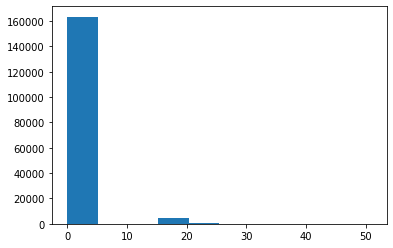

In [29]:
plt.hist(u_flags,)

(array([6.19668e+05, 5.60000e+01, 4.53900e+03, 2.18500e+03, 2.03000e+02,
        6.90000e+01, 0.00000e+00, 5.00000e+00, 1.26000e+02, 7.00000e+00]),
 array([ 0. ,  6.2, 12.4, 18.6, 24.8, 31. , 37.2, 43.4, 49.6, 55.8, 62. ]),
 <BarContainer object of 10 artists>)

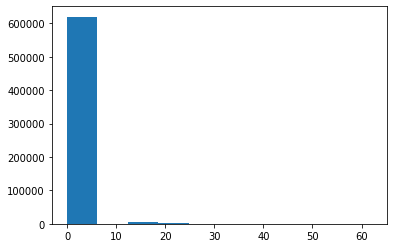

In [28]:
plt.hist(r_flags)